### Title: Backtesting using backtrader
Author: Tan Zhi Lun  
Contact: zhilun296@gmail.com

### The library and strategy
Backtrader is a python library that aims to streamline the backtesting process. In a nutshell, the "Cerebro" class acts as the main engine of the library; data and strategies can be fed to it in order to calculate the final returns. Please refer to [their documentation](https://backtrader.com/docu/) for more details.

The strategy that will be used for backtesting demonstration purposes in this file is an extremely simple Bollinger Bands strategy, where:  
1. A short order will be placed if the price closes above the Upper Bollinger Band
2. A long order will be placed if the price closes below the Lower Bollinger Band

The timeframe of the strategy will be 1 minute, during a one day period in 2017.

At the end, we will also contrast this strategy vs a buy and hold.

### 1. Bollinger Bands Backtest

In [5]:
import backtrader as bt

# Define the strategy as a separate class, which will be fed into the Cerebro engine to calculate returns

# The first demonstration is Bollinger Bands strategy
class BBands(bt.Strategy):
    
    # Define parameters for ease of change
    params = (('number',20),('deviation',2.0),('order_percentage',0.02),('ticker','EURUSD'), ('leverage',100))
    
    def __init__(self):
        # Data will be fed into the Cerebro engine later
        self.bollinger_bands = bt.indicators.BollingerBands(
            self.data.close, period=self.params.number, devfactor=self.params.deviation,
            plotname='Bollinger Bands')
        self.dataclose = self.datas[0].close
        self.order = None
        
    # To log orders for review
    def notify_order(self, order):
        if order.status in [order.Completed]:             
            self.bar_executed = len(self)
            self.entry_price = self.data.close[0]
    
    def next(self):
        # If there are no open positions, and close price is above the upper BBand, a sell is executed
        if not self.position:
            if self.data.close[0] > self.bollinger_bands.lines[1]:
                self.size = self.broker.cash*self.params.order_percentage*100/self.data.close[0]
                self.lots = round(self.size/100000,2)
                print('Sell {} lots of {} at {} on {}'.format \
                      (self.lots, self.params.ticker, self.data.close[0],self.datas[0].datetime.datetime(0)))
                self.sell(size=self.size)
                
        # If there are no open positions, and close price is below lower BBand, a buy is executed
            if self.data.close[0] < self.bollinger_bands.lines[2]:           
                self.size = self.broker.cash*self.params.order_percentage*100/self.data.close[0]
                self.lots = round(self.size/100000,2)
                print('Buy {} lots of {} at {} on {}'.format \
                      (self.lots, self.params.ticker, self.data.close[0],self.datas[0].datetime.datetime(0)))
                self.buy(size = self.size)
        
        # The order is closed once it falls within a range around the mean value
        else:
            if abs(self.data.close[0] - self.bollinger_bands.lines[0]) < 0.0002\
                or len(self)>=(self.bar_executed+45):
                print('Close order of {} lots of {} at {} on {} at entry {}'.format \
                      (self.lots, self.params.ticker, self.data.close[0],self.datas[0].datetime.datetime(0), self.entry_price))
                self.close()

In [6]:
# This will be used to contrast against the Bollinger Bands strategy later
class BuyHold(bt.Strategy): 
    
    # Log orders
    def notify_order(self, order):
        if order.status in [order.Completed]:             
            self.bar_executed = len(self)
            self.entry_price = self.data.close[0] 
    
    # Enter trade at the beginning
    def next(self):
        if self.position.size ==0 and len(self) < 100:
            #size here is the actual amount invested, leverage just ALLOWS for this
            size = self.broker.cash*0.02*100/self.data.close[0]
            lots = round(size/100000,2)
            print('Buy {} lots of {} at {} on {}'.format \
            (lots, 'EURUSD', self.data.close[0],self.datas[0].datetime.datetime(0)))
            self.buy(size = size)

Starting Portfolio Value: 100000
Sell 1.47 lots of EURUSD at 1.36386 on 2017-04-28 00:43:00
Close order of 1.47 lots of EURUSD at 1.36375 on 2017-04-28 00:44:00 at entry 1.36375
Buy 1.47 lots of EURUSD at 1.36356 on 2017-04-28 01:04:00
Close order of 1.47 lots of EURUSD at 1.3635 on 2017-04-28 01:07:00 at entry 1.3635
Buy 1.47 lots of EURUSD at 1.36342 on 2017-04-28 01:34:00
Close order of 1.47 lots of EURUSD at 1.36345 on 2017-04-28 01:35:00 at entry 1.36345
Buy 1.47 lots of EURUSD at 1.36334 on 2017-04-28 01:38:00
Close order of 1.47 lots of EURUSD at 1.3633600000000001 on 2017-04-28 01:39:00 at entry 1.3633600000000001
Buy 1.47 lots of EURUSD at 1.36319 on 2017-04-28 01:40:00
Close order of 1.47 lots of EURUSD at 1.3632799999999998 on 2017-04-28 01:42:00 at entry 1.36324
Buy 1.47 lots of EURUSD at 1.36297 on 2017-04-28 01:43:00
Close order of 1.47 lots of EURUSD at 1.36312 on 2017-04-28 01:50:00 at entry 1.3630200000000001
Buy 1.47 lots of EURUSD at 1.36246 on 2017-04-28 01:59:00
Cl

<IPython.core.display.Javascript object>


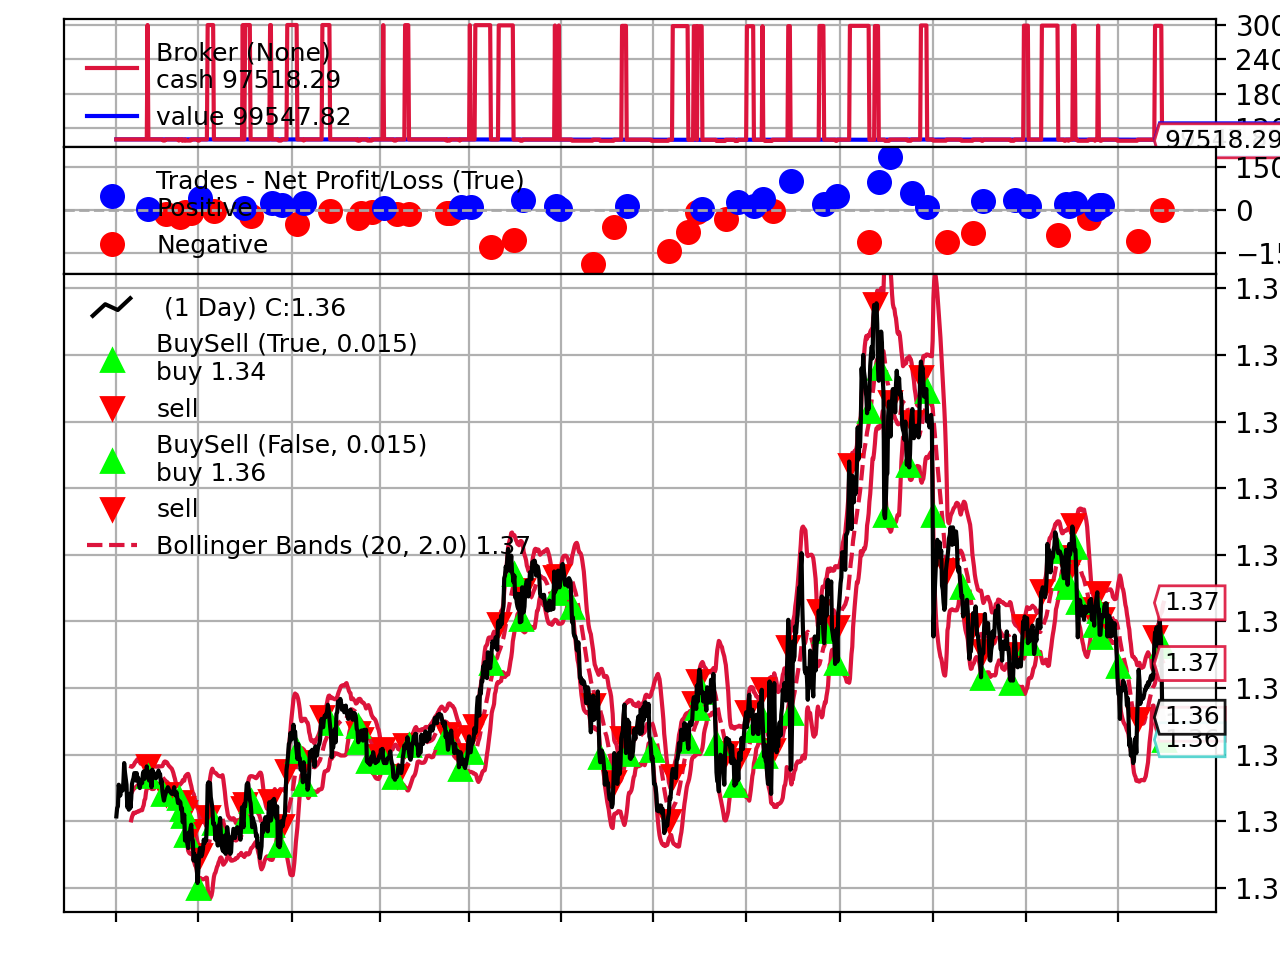

[[<Figure size 640x480 with 3 Axes>]]

In [11]:
import pandas as pd
import backtrader as bt

# Input data
filename = "USDCAD_out_2017_0428.csv"

# Adding in Cerebro and analyzers to give key statistics
cerebro = bt.Cerebro()
cerebro.addobserver(bt.observers.BuySell)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name = 'drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns',tann=253)

# Setting cash to be 100000
# Assume flat rate per trade, and zero bid ask spread (as per brokers like Pepperstone)
cerebro.broker.setcash(100000)
cerebro.broker.setcommission(leverage = 100, commission = 0.0000376)

# Input data
input_prices = pd.read_csv(filename, index_col = 'datetime', parse_dates=True)
feed = bt.feeds.PandasData(dataname = input_prices)

# Feed data and strategy to Cerebro
strategy = BBands
cerebro.adddata(feed)
cerebro.addstrategy(strategy)

# Print out key statistics
print('Starting Portfolio Value: {}' .format(round(cerebro.broker.getvalue())))
strats = cerebro.run()
strat = strats[0]
print('Final Portfolio Value: {}' .format(round(cerebro.broker.getvalue())))
print('Sharpe Ratio:', strat.analyzers.sharpe.get_analysis()['sharperatio'])
print('Max Drawdown:', round(strat.analyzers.drawdown.get_analysis().max.moneydown,2))
print('Drawdown Length:', strat.analyzers.drawdown.get_analysis().len)
print('Annualized Return:', round(strat.analyzers.returns.get_analysis()['rnorm100'],2),'%')

cerebro.plot(volume=False, fmt_x_data='%H:%M', fmt_x_ticks = '%H:%M')

**Note that the plot has interactive functions, such as the 'Zoom to rectangle' (second from right) which allows a close up view of the selected area.**

### 2. Buy and Hold Backtest

Starting Portfolio Value: 100000
Buy 1.47 lots of EURUSD at 1.3632600000000001 on 2017-04-28 00:00:00
Final Portfolio Value: 100170
Sharpe Ratio: None
Max Drawdown: 809.82
Drawdown Length: 368
Annualized Return: 53.68 %


<IPython.core.display.Javascript object>


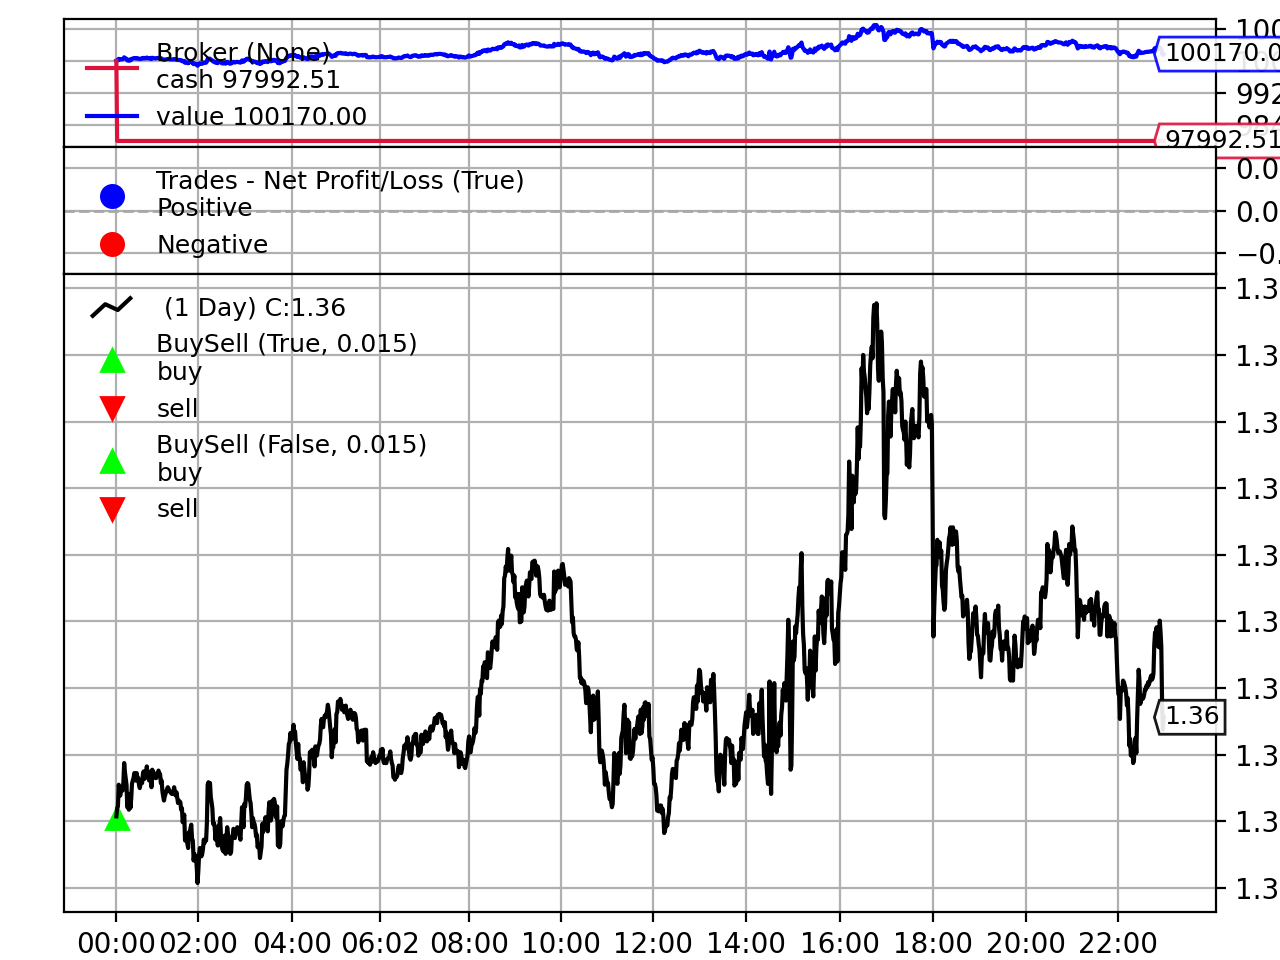

[[<Figure size 640x480 with 3 Axes>]]

In [10]:
# Input data
filename = "USDCAD_out_2017_0428.csv"

# Adding in Cerebro and analyzers to give key statistics
cerebro = bt.Cerebro()
cerebro.addobserver(bt.observers.BuySell)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name = 'drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns',tann=253)

# Setting cash to be 100000
# Assume flat rate per trade, and zero bid ask spread (as per brokers like Pepperstone)
cerebro.broker.setcash(100000)
cerebro.broker.setcommission(leverage = 100, commission = 0.0000376)

# Input data
input_prices = pd.read_csv(filename, index_col = 'datetime', parse_dates=True)
feed = bt.feeds.PandasData(dataname = input_prices)

# Feed data and strategy to Cerebro
strategy = BuyHold
cerebro.adddata(feed)
cerebro.addstrategy(strategy)

# Print out key statistics
print('Starting Portfolio Value: {}' .format(round(cerebro.broker.getvalue())))
strats = cerebro.run()
strat = strats[0]
print('Final Portfolio Value: {}' .format(round(cerebro.broker.getvalue())))
print('Sharpe Ratio:', strat.analyzers.sharpe.get_analysis()['sharperatio'])
print('Max Drawdown:', round(strat.analyzers.drawdown.get_analysis().max.moneydown,2))
print('Drawdown Length:', strat.analyzers.drawdown.get_analysis().len)
print('Annualized Return:', round(strat.analyzers.returns.get_analysis()['rnorm100'],2),'%')

cerebro.plot(volume=False, fmt_x_data='%H:%M', fmt_x_ticks = '%H:%M')

### 3. Limitations
While it is assumed that the bid ask spread is 0 but rather there is a flat commission rate for each trade (as per brokers such as Pepperstone), one limitation that has not been included is with regards to the swap. While it does not affect this particular iteration as it is intraday and there are no overnight holdings, this limitation must be kept in mind when using backtrader.  

One potential simple approximation or workaround is to apply a different commission rate:
1. If the strategy has a 50:50 mix of long and short trades, the swap may be ignored.
2. If the strategy is long more often than short or vice versa, a higher or lower commission may be required depending on the currency pair.   
E.g. if the swap for a particular currency pair is negative 100 basis points when going long, and if the strategy is long more often, a higher commission should then be applied.